# Set Up #

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from scipy import special
from scipy import optimize
from scipy import spatial

np.random.seed(666)

In [6]:
import matplotlib
matplotlib.__version__

'3.1.1'

In [2]:
'''These functions generate distributions on which
   we can run the Diffusion Condensation
   algorithm. They are pasted straight from the
   paper's github repository.'''

def barbell(N, beta=1):
    '''Generate Uniformly-Sampled 2-D Barbell'''
    X = [[],[]] # init data list [[x],[y]] 
    C = [] # init color list for plotting
    k = 1
    while k <= N:
        x = (2 + beta/2)*np.random.uniform()
        y = (2 + beta/2)*np.random.uniform()
            
        if (x - 0.5)**2 + (y - 0.5)**2 <= 0.25:
            X[0].append(x)
            X[1].append(y)
            C.append(0)
            k += 1
                
        elif abs(x - 1 - beta/4) < beta/4 and abs(y - 0.5) < 0.125:
            X[0].append(x)
            X[1].append(y)
            C.append(1)
            k += 1
                
        elif (x - 1.5 - beta/2)**2 + (y - 0.5)**2 <= 0.25:
            X[0].append(x)
            X[1].append(y)
            C.append(2)
            k += 1
                
    return np.asarray(X), np.asarray(C)
    
    
def tree(N, radius=1, levels=3):
    '''Generate Uniformly-Sampled 2-D Tree with 2**(levels) Branches'''
    X = [[],[]] # init data list [[x],[y]] 
    C = [] # init color list for plotting
        
    s = 0; root = [s, s] # root node position
    omega = np.pi/4 # half of anlge between branches
    xtop = np.cos(omega); ytop = np.sin(omega)
    xbot = np.cos(-omega); ybot = np.sin(-omega)
        
    for l in range(levels): # nuber of fork nodes
        for n in range(2**l): # quantify branch doubling 
            for i in range(int(N/(levels*2*(2**l)))): # uniform sample
                ## Top branch of current node
                top = np.random.uniform() # top branch sample
                X[0].append(root[0] + radius*top*xtop) # x
                X[1].append(root[1] + radius*top*ytop) # y
                    
                ## Bottom branch of current node
                bottom = np.random.uniform() # bottom branch sample
                X[0].append(root[0] + radius*bottom*xbot) # x
                X[1].append(root[1] + radius*bottom*ybot) # y
                C.extend([l,l])
                
            root[1] -= 2*s # decrease y coordinate of root node
                
        root[0] += radius*xtop # increase x to end of current line
        root[1] = radius*ytop # move y to end of currrent line (reset y)
        radius =  radius / 2 # decrease radius
        s = np.sqrt(2)*radius # compute new branch length
        root[1] += n*2*s # set next y coordinate
                
    return np.asarray(X), np.asarray(C)
    
    
def gaussian_mix(N, num_clusters=3, sigma_min=.1, sigma_max=.3):
    '''Generate (3) Gaussian Clusters'''
    X = [[],[]] # init data list [[x],[y]] 
    C = [] # init color list for plotting
    
    for cluster in range(int(num_clusters)):
        cov = np.random.uniform(sigma_min, sigma_max)*np.diag(np.ones(2))
        mu = [[0.0, 0.5],[1.0, 1.0],[1.0, 0.0]]
           
        for _ in range(int(N/num_clusters)):
            sx, sy = np.random.multivariate_normal(mu[cluster], cov)
            X[0].append(sx); X[1].append(sy) # x; y
            C.append(cluster)
            
    return np.asarray(X), np.asarray(C)
    
    
def hyperuniform_circle(N):
    '''Generate Hyperuniformly-Sampled 2-D Circle'''
    X = [[],[]] # init data list [[x],[y]] 
    C = np.linspace(0, 1, N) # init color list for plotting
        
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
        
    for t in theta:
        X[0].append(np.cos(t)) # x
        X[1].append(np.sin(t)) # y
            
    return np.asarray(X), np.asarray(C)
    
    
def hyperuniform_ellipse(N, a=1, b=2):
    '''Generate Hyperuniformly-Sampled 2-D Ellipse'''
    assert(a < b) # a must be length of minor semi-axis; b major semi-axis
        
    X = [[],[]] # init data list [[x],[y]] 
    C = np.linspace(0, 1, N) # init color list for plotting
        
    angles = 2*np.pi*np.arange(N)/N
        
    if a != b:
        '''Given N points, combine scipy elliptic integral + optimize to find 
           N equidistant points along ellilpse manifold, then convert to angles'''
        e = np.sqrt(1.0 - a**2 / b**2)
        tot_size = special.ellipeinc(2.0*np.pi, e)
        arc_size = tot_size/N
        arcs = np.arange(N)*arc_size
        res = optimize.root(
                lambda x: (special.ellipeinc(x, e) - arcs), angles)
        angles = res.x
            
        arcs = special.ellipeinc(angles, e)
    
    for t in angles:
        X[0].append(a*np.cos(t)) # x
        X[1].append(b*np.sin(t)) # y
            
    return np.asarray(X), np.asarray(C)
    
def uniform_circle(N):
    '''Generate Hyperuniformly-Sampled 2-D Circle'''
    X = [[],[]] # init data list [[x],[y]] 
    C = np.linspace(0, 1, N) # init color list for plotting
        
    theta = np.random.uniform(0, 2*np.pi, N)
    theta.sort()
        
    for t in theta:
        X[0].append(np.cos(t)) # x
        X[1].append(np.sin(t)) # y
            
    return np.asarray(X), np.asarray(C)
    
def twospirals(n_points, noise=.2):
    """Generate Two Nested Spirals"""
    n = np.sqrt(np.random.rand(n_points,1)) * 220 * (2*np.pi)/360
    dx = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    dy = np.sin(n)*n + np.random.rand(n_points,1) * noise
        
    X = np.vstack((np.hstack((dx,dy)),np.hstack((-dx,-dy)))).T # data 
    C = np.hstack((np.zeros(n_points),np.ones(n_points))) # colors for plot
        
    return X, C


'''This plots the diffusion process over time.'''
def plot_diffusion(Xs, C):
    cols = 5
    rows = np.shape(Xs)[0] // cols + 1
    fig, ax = plt.subplots(rows, cols, figsize = (20, rows * 5))
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            if index < np.shape(Xs)[0]:
                ax[i][j].scatter(Xs[index].T[0], Xs[index].T[1], c = C, s = 5)
                if i == 0 and j == 0:
                    plt_xlim = ax[0][0].get_xlim()
                    plt_ylim = ax[0][0].get_ylim()
            ax[i][j].tick_params(axis='both', which='both', bottom=False, top=False,
                                 labelbottom=False, right=False, left=False,
                                 labelleft=False)
            ax[i][j].set_xlim(plt_xlim)
            ax[i][j].set_ylim(plt_ylim)
            ax[i][j].set_aspect('equal')

# Diffusion Condensation Algorithm #

In [3]:
def condense(X, eps):
    N = np.shape(X)[0]
    Q_p = np.eye(N)
    Q_diff = math.inf
    Xs = [X.copy()]
    
    i = 0
    i_prev = -2
    while i - i_prev > 1:
        i_prev = i
        print('i_prev:\t', i_prev)
        while Q_diff >= 1e-4:
            i += 1
            
            #Construct the kernel K
            A = spatial.distance.squareform(spatial.distance.pdist(X, metric = 'euclidean'))
            A = np.exp(-(A ** 2) / eps)
            Q = np.diag(np.sum(A, axis = 0))
            Q_inv = np.diag(1./np.sum(A, axis = 0))
            K = Q_inv @ A @ Q_inv
            
            #Construct the diffusion operator P
            D_inv = np.diag(1./np.sum(K, axis = 0))
            P = D_inv @ K
            X_1 = P @ X
            
            #Update matrices
            Q_diff = np.max(np.abs(np.diag(Q) - np.diag(Q_p)))
            Q_p = Q.copy()
            
            #Save data
            X = X_1.copy()
            Xs.append(X)
        eps *= 2
        Q_diff = math.inf
    return Xs

# Hyperuniform Circle Condensation #

In [4]:
hucX, hucC = hyperuniform_circle(2 ** 7)
hucX = hucX.T

hucN = np.shape(hucX)[0]
huceps = 2 * np.pi / hucN
hucXs = condense(hucX, huceps)

i_prev:	 0
i_prev:	 45


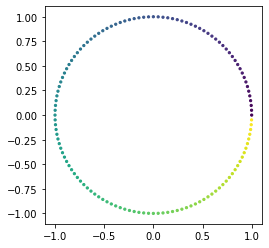

In [5]:
plt.scatter(hucX.T[0], hucX.T[1], c = hucC, s = 5)
plt.gca().set_aspect('equal')

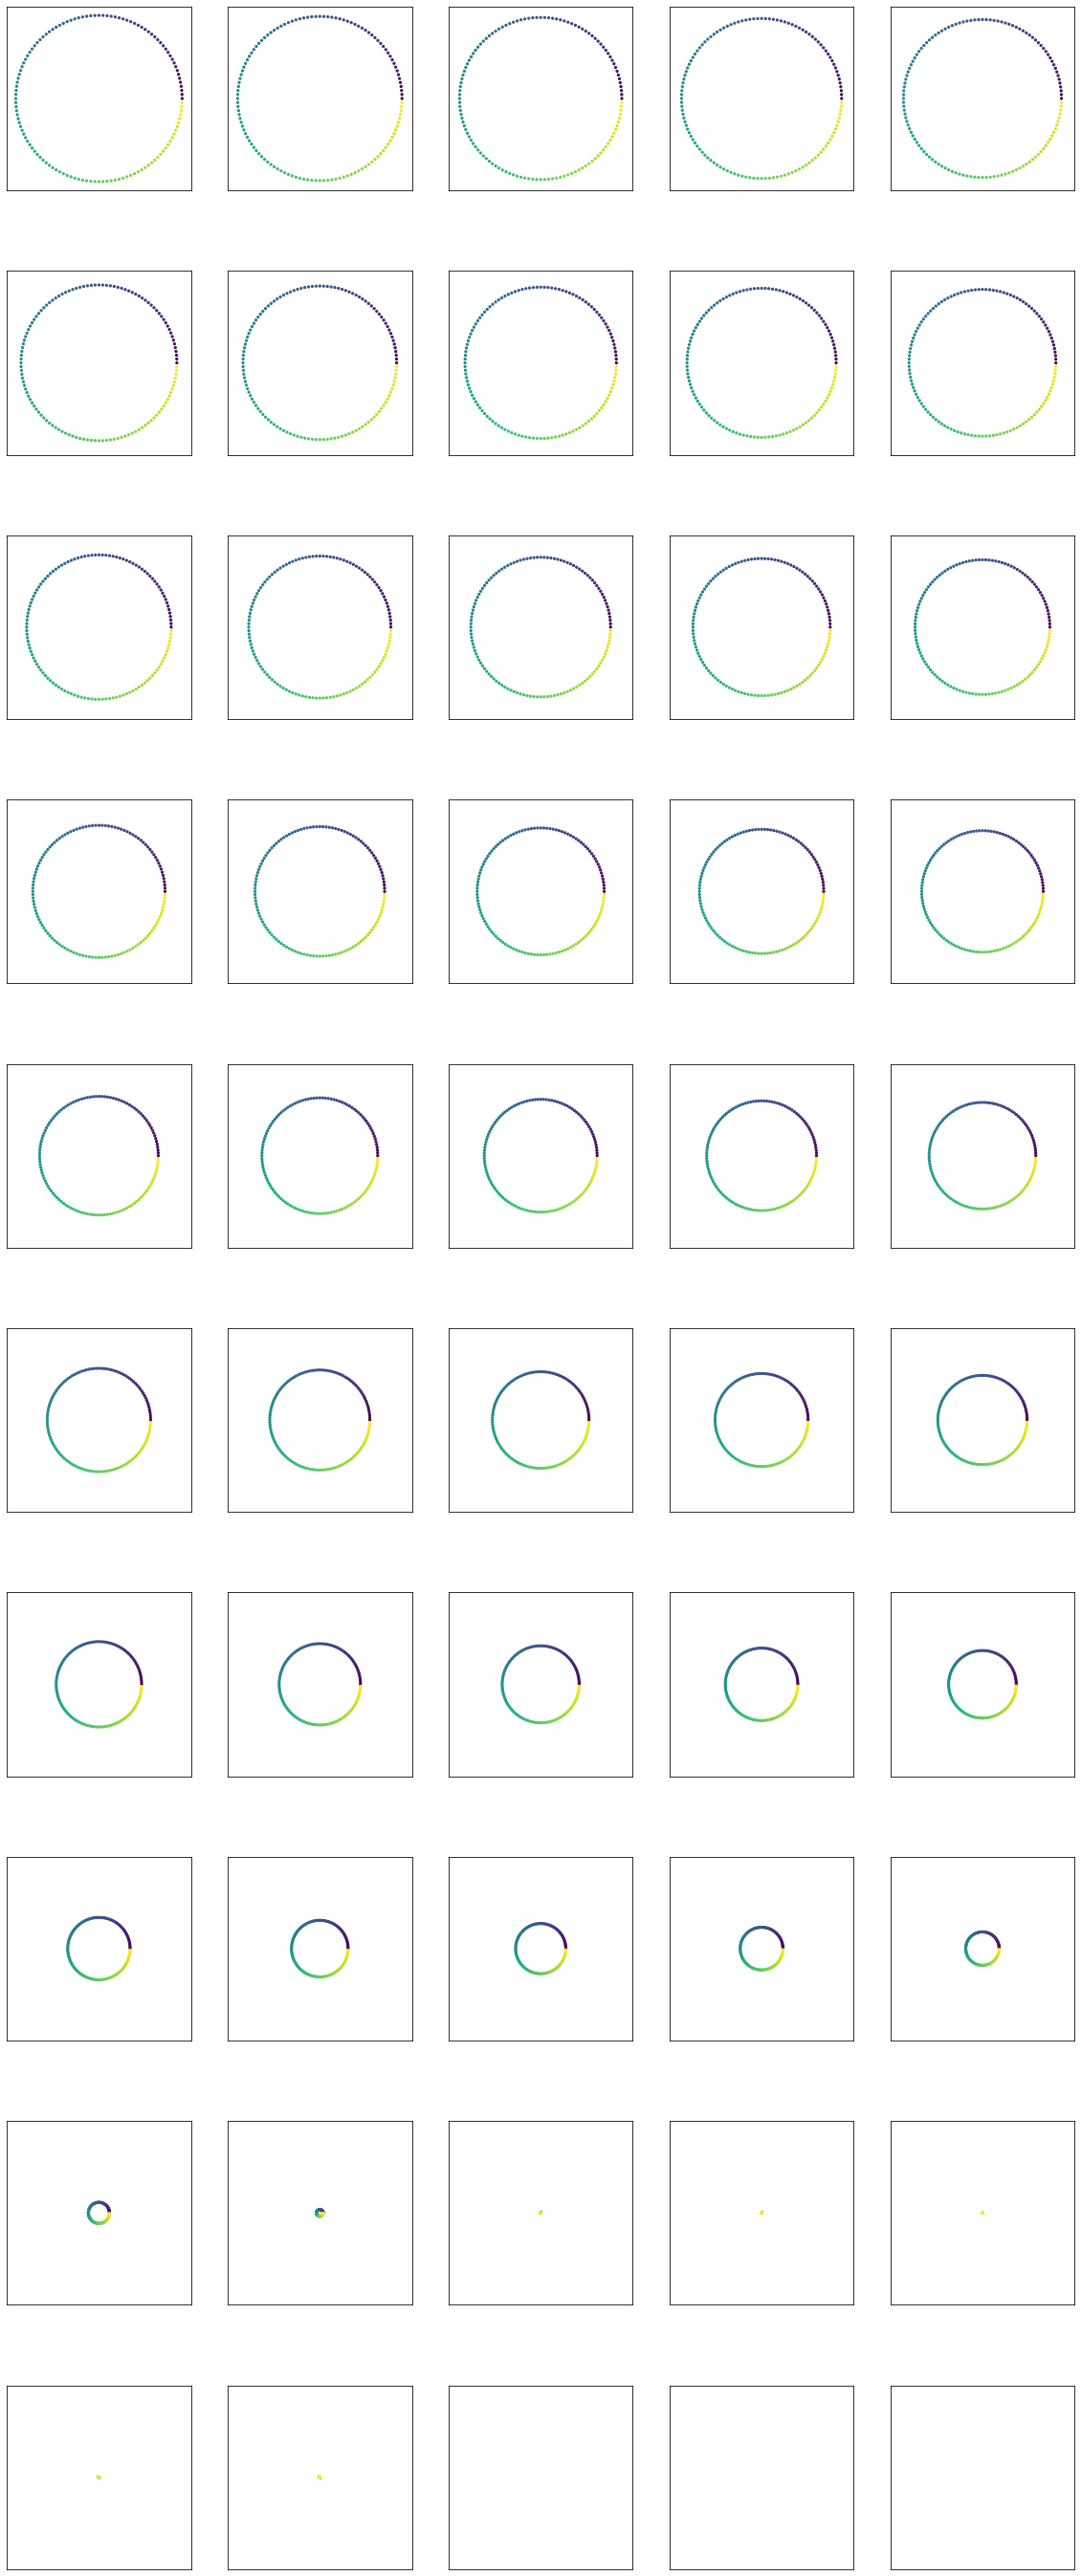

In [6]:
plot_diffusion(hucXs, hucC)

# Hyperuniform Ellipse Condensation #

In [7]:
hueX, hueC = hyperuniform_ellipse(2 ** 7, a = 0.5, b = 1)
hueX = hueX.T

hueN = np.shape(hueX)[0]
hueeps = np.pi / hueN
hueXs = condense(hueX, hueeps)

i_prev:	 0
i_prev:	 58
i_prev:	 60
i_prev:	 92


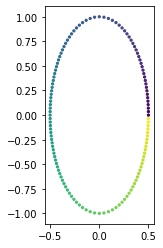

In [8]:
plt.scatter(hueX.T[0], hueX.T[1], c = hueC, s = 5)
plt.gca().set_aspect('equal')

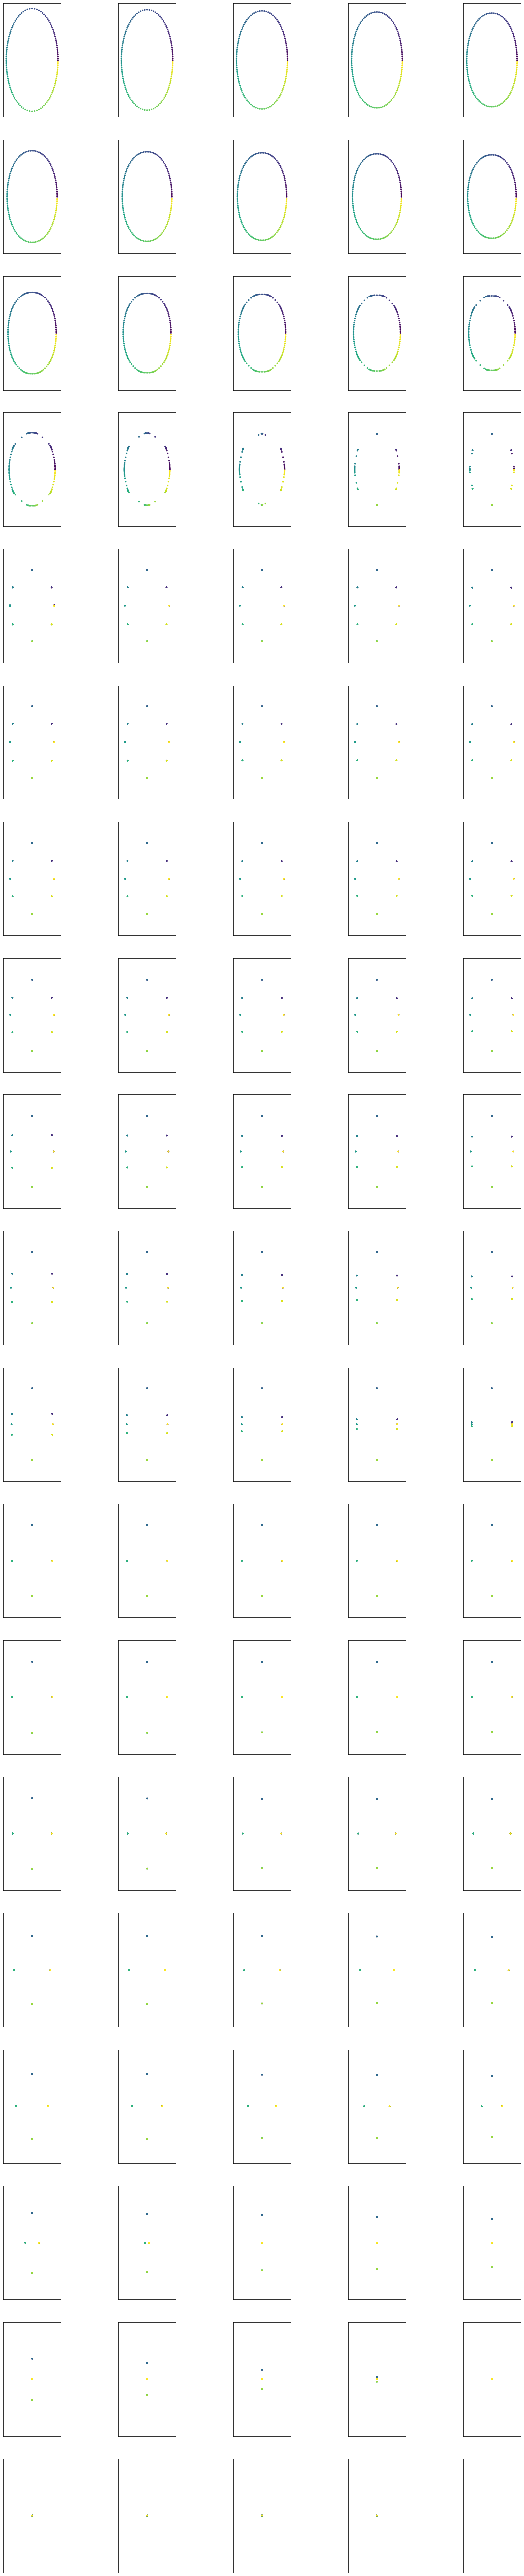

In [9]:
plot_diffusion(hueXs, hueC)

# Tree #

In [10]:
tX, tC = tree(2 ** 7, 1, 3)
tX = tX.T

tN = np.shape(tX)[0]
teps = np.pi / tN
tXs = condense(tX, teps)

i_prev:	 0
i_prev:	 36
i_prev:	 201
i_prev:	 284
i_prev:	 315


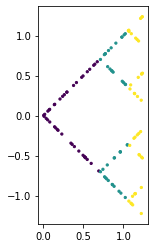

In [11]:
plt.scatter(tX.T[0], tX.T[1], c = tC, s = 5)
plt.gca().set_aspect('equal')

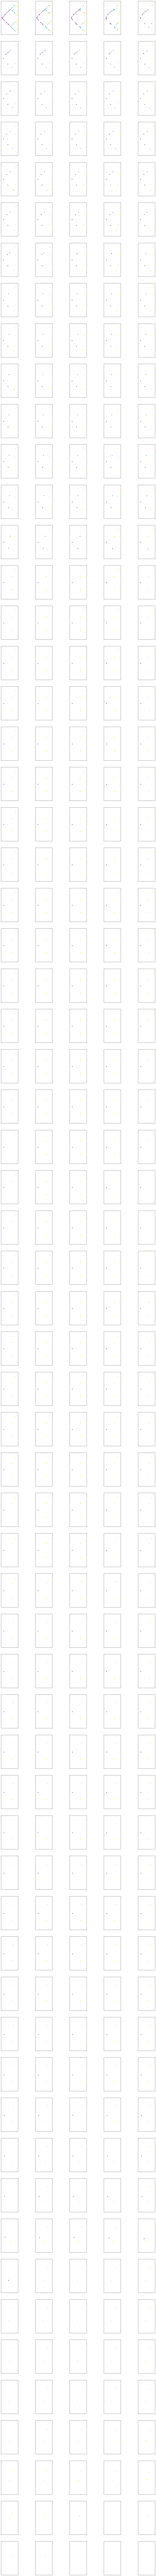

In [12]:
plot_diffusion(tXs, tC)

# Noisy Tree #

In [13]:
ntX, ntC = tree(2 ** 7, 1, 6)
ntX = ntX.T
gn = np.random.normal(0, 0.05, ntX.shape)
ntX += gn

ntN = np.shape(ntX)[0]
nteps = np.pi / ntN
ntXs = condense(ntX, nteps)

i_prev:	 0
i_prev:	 32
i_prev:	 34
i_prev:	 74


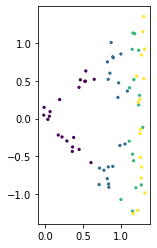

In [14]:
plt.scatter(ntX.T[0], ntX.T[1], c = ntC, s = 5)
plt.gca().set_aspect('equal')

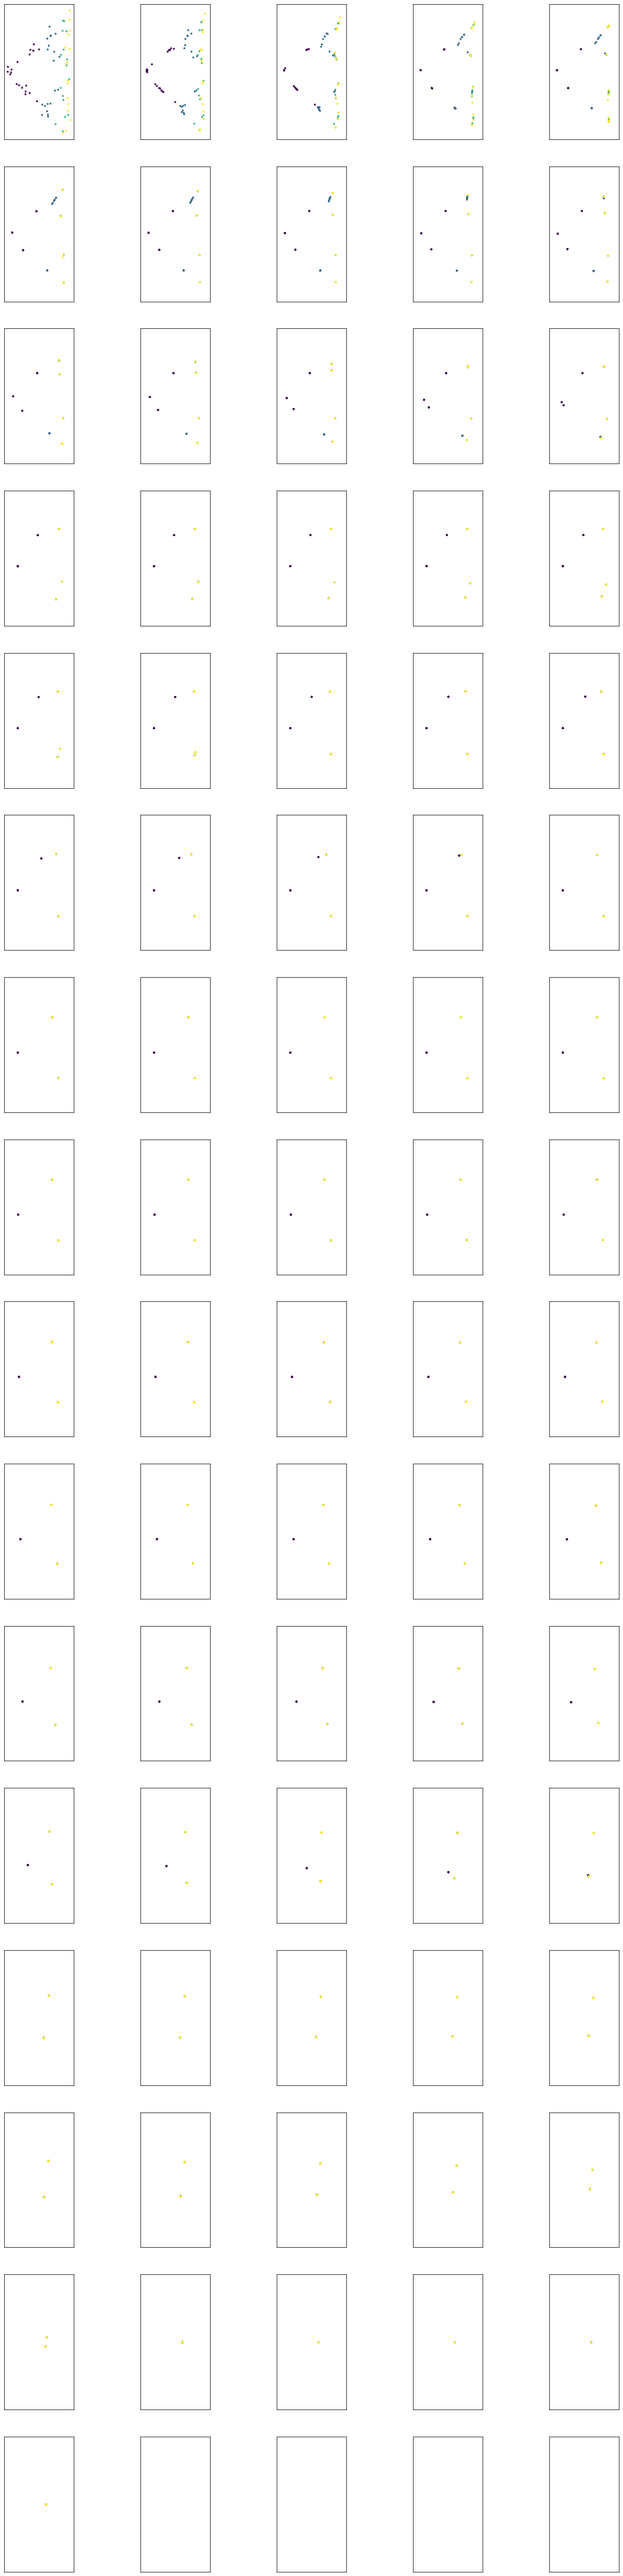

In [15]:
plot_diffusion(ntXs, ntC)